### VS AutoEncoder

AutoEncoder：  
   - 只是学习学习input本身的低维表示，而不是学习众多input在低维的分布规律。自己重构自己。
   - loss仅仅只是考虑，当前输入与输出，对应pixel的binary cross-entropy或者是MSE（对于不是二值输入，比如0到10的一个连续分布）

### VS PCA

PCA：
   - 线性变换，选择variance大的维度，来表示原始数据的大部分信息

VAE：
   - 非线性变换，不会有对特征降维后的质量的依赖，对噪声的适应性更强

### VS Adversarial AE

Adversarial AE：
   - 期望低维表示服从（0， 1）正态分布。So，加入一个Discriminator，判别低维表示是否服从该正态分布。
   
VAE：
   - 不用Discriminator的方式判别，而是加入KL损失。低维分布p与高斯分布q要尽量相似，KL要尽量小。

### VAE实现

图像低维表示服从一个分布，而该分布难以求解，有点类似EM算法中考虑隐变量的思路。不过两者还是不同的。一个是求数据本身低维表示的分布，一个是求模型中间自变量的分布。求解算法也是不同的，使用神经网络反向传播的方法求解，显然轻松许多。

损失函数，与AE相同的重构损失，加上相对熵KL散度（可加权）：
$$
D_{\mathrm{KL}}(P \| Q)=-\sum_{i} P(i) \ln \frac{Q(i)}{P(i)}
$$
重构损失 + KL散度，也就是**ELBO**损失函数。注意框架内部损失函数的计算实现过程，这影响到自定义KL的修正。

#### 怎么计算KL？

$$
p(x)=\frac{1}{\sqrt{2 \pi} \sigma} \exp \left(-\frac{(x-\mu)^{2}}{2 \sigma^{2}}\right)
$$

$$
\begin{aligned} K L(p, q) &=-\int p(x) \log q(x) d x+\int p(x) \log p(x) d x \\ &=\frac{1}{2} \log \left(2 \pi \sigma_{2}^{2}\right)+\frac{\sigma_{1}^{2}+\left(\mu_{1}-\mu_{2}\right)^{2}}{2 \sigma_{2}^{2}}-\frac{1}{2}\left(1+\log 2 \pi \sigma_{1}^{2}\right) \\ &=\log \frac{\sigma_{2}}{\sigma_{1}}+\frac{\sigma_{1}^{2}+\left(\mu_{1}-\mu_{2}\right)^{2}}{2 \sigma_{2}^{2}}-\frac{1}{2} \end{aligned}
$$

其中，在网络中，$\sigma_{2}和\mu_2$来自（0,1）正态分布。

#### 正向计算，反向计算，传递什么参数？

$$
E_{z \sim q_{_\theta}\left(z | x_{i}\right)}\left[\log p_{\phi}\left(x_{i} | z\right)\right]
$$

Z来自从q分布的采样，采样怎么反向计算梯度？

So，令   $z = \mu + \sigma*\epsilon$，$\epsilon$服从（0，1）正态分布，反向传播就更新$\mu 和 \sigma$

### Keras简单实现

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.datasets import mnist

In [2]:
batch_size = 100
original_dim = 784
intermediate_dim = 256
latent_dim = 2
epochs = 50

#### encoder

In [3]:
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)

# 分别建立均值和方差计算网络
z_mean = Dense(latent_dim)(h)
z_var = Dense(latent_dim)(h)

In [5]:
def sampling(args):
    # 采样
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.)
    return z_mean + z_var * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_var])

#### decoder

In [16]:
# 计算节点：可以在训练后重用
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_x = Dense(original_dim, activation='sigmoid')

# 结算结果tensor，不可在训练后重用
h_decoded = decoder_h(z)
x_decoded = decoder_x(h_decoded)

#### 损失函数

In [17]:
def vae_loss(x, x_decoded_mean):
    """elbo"""
    xent_loss = objectives.binary_crossentropy(x, x_decoded_mean)
    
    # / (batch_size * original_dim) ：防止KL损失过大，影响正常重构损失减小
    # 因为objectives.binary_crossentropy的实现中，除以了batch_size和original_dim
    kl_loss = 0.5 * K.sum(K.square(z_mean) + 
                                           K.square(z_var) - 
                                           K.log(1e-8 + K.square(z_var)) 
                                           -1, 
                                       axis=-1) / (batch_size * original_dim)  
    
    return xent_loss + kl_loss

In [18]:
vae = Model(x, x_decoded)
vae.compile(optimizer='rmsprop', loss=vae_loss)

#### 训练

In [19]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
            shuffle=True,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 6s 93us/step - loss: 0.2209 - val_loss: 0.2047
Epoch 2/50
60000/60000 [==============================] - 5s 89us/step - loss: 0.2008 - val_loss: 0.1979
Epoch 3/50
60000/60000 [==============================] - 5s 88us/step - loss: 0.1960 - val_loss: 0.1951
Epoch 4/50
60000/60000 [==============================] - 6s 92us/step - loss: 0.1930 - val_loss: 0.1931
Epoch 5/50
60000/60000 [==============================] - 5s 84us/step - loss: 0.1908 - val_loss: 0.1917
Epoch 6/50
60000/60000 [==============================] - 5s 87us/step - loss: 0.1891 - val_loss: 0.1905
Epoch 7/50
60000/60000 [==============================] - 5s 87us/step - loss: 0.1878 - val_loss: 0.1894
Epoch 8/50
60000/60000 [==============================] - 5s 84us/step - loss: 0.1868 - val_loss: 0.1893
Epoch 9/50
60000/60000 [==============================] - 5s 89us/step - loss: 0.1859 - val_loss: 0.1885
Epoch

#### 编码器查看效果

注意，网络中将latent_dim设为2，方便图示

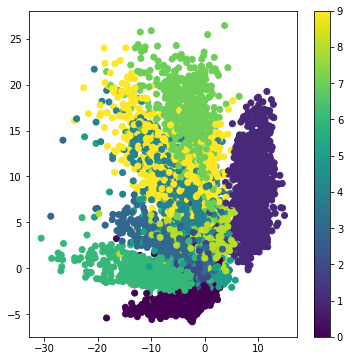

In [20]:
encoder = Model(x, z_mean)

x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

#### 生成器效果查看

In [21]:
decoder_input = Input(shape=(latent_dim,))  # latent_dim, 这里的“，”表示输入维度可变

_h_decoded = decoder_h(decoder_input)
_x_decoded = decoder_x(_h_decoded)

generator = Model(decoder_input, _x_decoded)

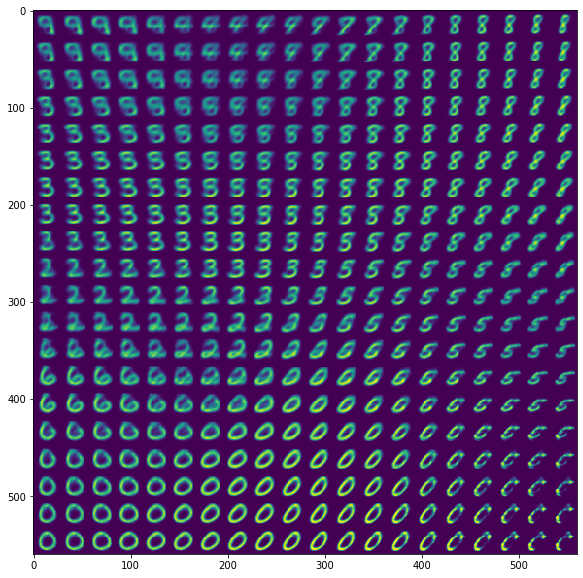

In [22]:
n = 20
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)

for i, xi in enumerate(grid_x):
    for j, yi in enumerate(grid_y):
        z_sample = np.array([[yi, xi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[(n - i - 1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()